 RR 간격                FFT 주파수
[5길이 시계열]         [주파수 벡터 150개]
     │                      │
   LSTM                 1D CNN
     │                      │
[벡터 출력1]        [벡터 출력2]
       └───── Concatenate ─────┘
                   ↓
               Dense Layers
                   ↓
              Sigmoid Output


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Preprocessing.py to Preprocessing.py


In [3]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from Preprocessing import load_data_npy, peaks_find

In [5]:
from google.colab import files
uploaded = files.upload()

Saving ppg_train.npy to ppg_train.npy


In [34]:
from collections import Counter
from Preprocessing import load_data_npy, peaks_find
import numpy as np

# usable 데이터 라벨 수 확인
usable_labels = []
for idx, sample in enumerate(split_array):
    rr = peaks_find(sample)
    if rr is not None and len(rr) >= 2:
        label = 0 if idx < 500 else 1
        usable_labels.append(label)

print("✅ usable 샘플 라벨 분포:", Counter(usable_labels))

✅ usable 샘플 라벨 분포: Counter({0: 99})


In [6]:
# ---------------------
# 1. RR 간격 입력 준비
# ---------------------
split_array = load_data_npy('ppg_train.npy')

In [7]:
def get_rr_intervals(data, max_len=5):
    peaks = peaks_find(data)
    if peaks is None or len(peaks) < 2:
        return None
    times = [p[0] for p in sorted(peaks)]
    rr = np.diff(times)
    if len(rr) < max_len:
        rr = np.pad(rr, (0, max_len - len(rr)), 'constant')
    else:
        rr = rr[:max_len]
    return rr

In [8]:
rr_list = []
fft_list = []
label_list = []

for idx, sample in enumerate(split_array):
    rr = get_rr_intervals(sample)
    if rr is not None:
        rr_list.append(rr)

        # FFT 처리
        fft = np.abs(np.fft.fft(sample))[:150]
        fft = MinMaxScaler().fit_transform(fft.reshape(-1, 1)).flatten()
        fft_list.append(fft)

        # 라벨
        label_list.append(0 if idx < 500 else 1)

# 배열화 및 reshape
X_rr = np.array(rr_list).reshape(-1, 5, 1)
X_fft = np.array(fft_list).reshape(-1, 150, 1)
y = np.array(label_list)

In [25]:
# K-Fold
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
accuracies = []

for train_index, val_index in kf.split(X_rr, y):
    print(f"\n📂 Fold {fold}")


📂 Fold 1

📂 Fold 1

📂 Fold 1

📂 Fold 1

📂 Fold 1


In [26]:
# 데이터 분할
Xrr_train, Xrr_val, Xfft_train, Xfft_val, y_train, y_val = train_test_split(
    X_rr, X_fft, y, test_size=0.2, random_state=42, stratify=y)
# 클래스 비율 유지되도록(정상0 부정맥1 고르게 포함되도록) stratiy=y 옵션 추가

In [27]:
# ---------------------
# 2. 모델 정의
# ---------------------

# RR 간격 → LSTM
input_rr = Input(shape=(5, 1))
x1 = LSTM(32)(input_rr)

# FFT → CNN
input_fft = Input(shape=(150, 1))
x2 = Conv1D(64, 3, activation='relu')(input_fft)
x2 = MaxPooling1D(2)(x2)
x2 = Flatten()(x2)

In [28]:
# 결합
merged = Concatenate()([x1, x2])
fc = Dense(32, activation='relu')(merged)
fc = Dropout(0.3)(fc)
output = Dense(1, activation='sigmoid')(fc)

model = Model(inputs=[input_rr, input_fft], outputs=output)

In [29]:
# ---------------------
# 3. 학습
# ---------------------
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
model.fit([Xrr_train, Xfft_train], y_train, epochs=20, batch_size=32, validation_data=([Xrr_val, Xfft_val], y_val))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 150, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 148, 64)   │        256 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 74, 64)    │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 32)        │      4,352 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4736)      │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 4768)      │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │    152,608 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 157,249 (614.25 KB)

 Trainable params: 157,249 (614.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.5000 - loss: 0.6882 - val_accuracy: 1.0000 - val_loss: 0.6085
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.5941 - val_accuracy: 1.0000 - val_loss: 0.5198
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.5045 - val_accuracy: 1.0000 - val_loss: 0.4092
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.3897 - val_accuracy: 1.0000 - val_loss: 0.2859
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.2706 - val_accuracy: 1.0000 - val_loss: 0.1720
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.1675 - val_accuracy: 1.0000 - val_loss: 0.0882
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0975 - val_accuracy: 1.0000 - val_loss: 0.0398
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0453 - val_accuracy: 1.0000 - val_loss: 0.0166

In [30]:
# ---------------------
# 4. 평가
# ---------------------
loss, acc = model.evaluate([Xrr_val, Xfft_val], y_val)
print(f"Validation Accuracy: {acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 5.4664e-05
Validation Accuracy: 1.0000


과적합 or 데이터 누수 가능성

🔸 1. 데이터가 너무 단순하거나 라벨이 명확한 경우
부정맥 데이터와 정상 데이터의 RR/FFT 차이가 너무 극명할 경우 → 분류는 쉬움

🔸 2. 같은 환자 샘플이 Train/Validation에 같이 포함된 경우
예를 들어 같은 환자의 데이터가 train/test에 중복될 경우, 모델이 진짜 일반화 능력을 본 게 아님

🔸 3. 데이터 수가 적은 경우 (특히 RR은 1000개 중 일부만 쓰였음)
학습 데이터 수가 작으면 high variance risk (일반화 어려움)

In [31]:
import collections
print("검증 데이터 라벨 분포:", collections.Counter(y_val))

검증 데이터 라벨 분포: Counter({np.int64(0): 20})


In [32]:
print("y_val unique:", np.unique(y_val))
print("y_pred unique:", np.unique(y_pred))

y_val unique: [0]
y_pred unique: [0]


# 1. 검증 데이터에 정상 클래스(0)만 포함
=> 현재 y_val이 전부 0이라는 건 검증 데이터셋에 부정맥(1) 샘플이 하나도 안 포함된 상태

=> 이 경우 모델이 아무리 잘해도 정상만 예측하게 되고, Confusion Matrix는 당연히 한 줄짜리가 돼서 에러가 남.


# 2. 무작위 분할이 클래스 불균형을 유발
=> train_test_split() 함수는 기본적으로 라벨 분포를 고려하지 않아서 이런 일이 생길 수 있음.

=> 특히 데이터 수가 적고, RR 간격 기반 모델에서는 usable sample 수가 줄기 때문에 더 쉽게 발생 가능.

# Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


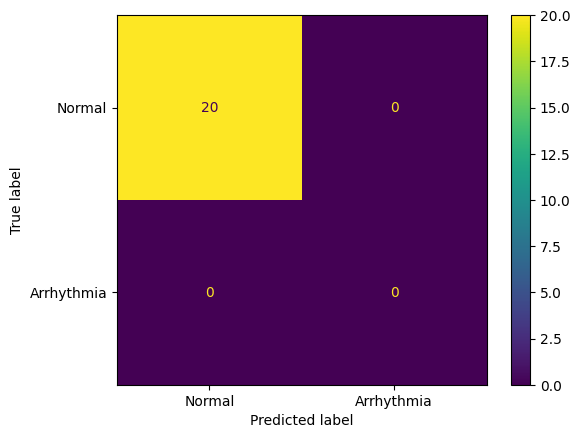

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측
y_pred = (model.predict([Xrr_val, Xfft_val]) > 0.5).astype("int32").flatten()

# 혼동 행렬 계산 (labels=[0, 1] 명시)
cm = confusion_matrix(y_val, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Arrhythmia"])
disp.plot()
plt.show()